In [1]:
from google.colab import drive
from pathlib import Path
import pandas as pd
import numpy as np
import re
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

drive.mount('/content/drive')

BASE_DIR     = Path("/content/drive/MyDrive/ACADS/CSCI 299.2/Research Paper/Datasets")
ANALYSIS_DIR = BASE_DIR / "ANALYSIS"

# Load the input file (we will be creating a copy of the RANK SCORE full grid dataset for the test-train split)
rs_grid_path = ANALYSIS_DIR / "RANK_SCORE_full_grid.xlsx"
df = pd.read_excel(rs_grid_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Identify & drop Rank Score columns: *_RS and exact RANK_SCORE, plus Player_Role
pattern = re.compile(r'(?:_RS$)|(?:^RANK_SCORE$)', flags=re.IGNORECASE)
rankscore_cols = [c for c in df.columns if pattern.search(c)]

extra_drop = ['Age', 'OLD', 'NEW', 'Pos1', 'Pos2', 'Player_Role']  # drop this too if present
to_drop = rankscore_cols + [c for c in extra_drop if c in df.columns]

df_ml = df.drop(columns=to_drop, errors='ignore')

print("Dropped columns:", to_drop)
print("Remaining columns (first 20):", list(df_ml.columns)[:20])


Dropped columns: ['FG%_RS', '3P_RS', 'FT%_RS', 'TRB_RS', 'AST_RS', 'STL_RS', 'BLK_RS', 'TOV_RS', 'PTS_RS', 'RANK_SCORE', 'Age', 'OLD', 'NEW', 'Pos1', 'Pos2', 'Player_Role']
Remaining columns (first 20): ['Season', 'Player', 'G', 'GS', 'MP', 'FG%', '3P', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']


In [3]:
# Normalize 'Season' text
df_ml['Season'] = df_ml['Season'].astype(str).str.strip()

# Extract start year and sort Player ASC, SeasonStart DESC
def season_start_year(season: str) -> int:
    m = re.match(r'^\s*(\d{4})-(\d{4})\s*$', season)
    return int(m.group(1)) if m else -10**9  # push malformed to the bottom

df_ml['_SeasonStart'] = df_ml['Season'].apply(season_start_year)
df_ml.sort_values(by=['Player', '_SeasonStart'], ascending=[True, False], inplace=True)

df_ml.drop(columns=['_SeasonStart'], inplace=True)

df_ml.tail(10)

,Season,Player,G,GS,MP,FG%,3P,FT%,TRB,AST,STL,BLK,TOV,PTS
2295,2022-2023,"ŠARIĆ, Dario",57.0,12.0,14.1,0.458,0.8,0.829,3.6,1.3,0.4,0.1,1.0,6.4
3363,2021-2022,"ŠARIĆ, Dario",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4431,2020-2021,"ŠARIĆ, Dario",50.0,4.0,17.4,0.447,0.9,0.848,3.8,1.3,0.6,0.1,1.1,8.7
5499,2019-2020,"ŠARIĆ, Dario",66.0,51.0,24.7,0.476,1.3,0.844,6.2,1.9,0.6,0.2,1.3,10.7
386,2024-2025,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1454,2023-2024,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2522,2022-2023,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3590,2021-2022,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4658,2020-2021,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5726,2019-2020,"ŽIŽIĆ, Ante",22.0,0.0,10.0,0.569,0.0,0.737,3.0,0.3,0.3,0.2,0.5,4.4


In [4]:
# True Label Classification
# Ensure numeric types
df_ml['G']  = pd.to_numeric(df_ml['G'],  errors='coerce')
df_ml['GS'] = pd.to_numeric(df_ml['GS'], errors='coerce')
df_ml['MP'] = pd.to_numeric(df_ml['MP'], errors='coerce')

season = df_ml['Season'].astype(str).str.strip()
G  = df_ml['G'].fillna(0)
GS = df_ml['GS'].fillna(0)
MP = df_ml['MP']  # keep NaN to avoid accidental ROLEPLAYER

# DNP: did not play any game
is_dnp = G.eq(0)

# STARTER: using absolute GS threshold (includes bubble season override)
abs_starter = ((season == '2019-2020') & (GS >= 52)) | ((season != '2019-2020') & (GS >= 65))

# STARTER: via ratio / all-games-started
eps = 1e-9
ratio = GS.divide(G.replace(0, np.nan))
ratio_starter = (~abs_starter) & (~is_dnp) & ( (ratio >= (65/82) - eps) | (GS.eq(G)) )

# ROLEPLAYER: Minutes Played >= 14.4 (equivalent to 30% of play time of NBA regulation game)
# starter    = abs_starter | ratio_starter
starter    = abs_starter | ratio_starter | (MP >= 24) # MP >= 24 is to include Sixth Men (or first starter off the bench)
roleplayer = (~starter) & (~is_dnp) & (MP >= 14.4)

# 4) BENCHWARMER is the remainder
df_ml['CLASSIFICATION'] = np.select(
    [is_dnp, starter, roleplayer],
    ['DNP', 'STARTER', 'ROLEPLAYER'],
    default='BENCHWARMER'
)

df_ml.tail(10)

,Season,Player,G,GS,MP,FG%,3P,FT%,TRB,AST,STL,BLK,TOV,PTS,CLASSIFICATION
2295,2022-2023,"ŠARIĆ, Dario",57.0,12.0,14.1,0.458,0.8,0.829,3.6,1.3,0.4,0.1,1.0,6.4,BENCHWARMER
3363,2021-2022,"ŠARIĆ, Dario",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNP
4431,2020-2021,"ŠARIĆ, Dario",50.0,4.0,17.4,0.447,0.9,0.848,3.8,1.3,0.6,0.1,1.1,8.7,ROLEPLAYER
5499,2019-2020,"ŠARIĆ, Dario",66.0,51.0,24.7,0.476,1.3,0.844,6.2,1.9,0.6,0.2,1.3,10.7,STARTER
386,2024-2025,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNP
1454,2023-2024,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNP
2522,2022-2023,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNP
3590,2021-2022,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNP
4658,2020-2021,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNP
5726,2019-2020,"ŽIŽIĆ, Ante",22.0,0.0,10.0,0.569,0.0,0.737,3.0,0.3,0.3,0.2,0.5,4.4,BENCHWARMER


In [5]:
# Filter to 2024–2025 and exclude did-not-play rows ("DNP")
season_str = '2024-2025'
mask = (
    df_ml['Season'].astype(str).str.strip().eq(season_str) &
    ~df_ml['CLASSIFICATION'].astype(str).str.upper().eq('DNP')
)
true_labels = df_ml.loc[mask].copy()


In [6]:
# Save to ANALYSIS folder
out_path = ANALYSIS_DIR / "GROUND_TRUTH_2024_2025.xlsx"
os.makedirs(ANALYSIS_DIR, exist_ok=True)
true_labels.to_excel(out_path, index=False)

print(f"Saved ground-truth labels: {out_path}")
print(f"Rows saved: {len(true_labels)}")


Saved ground-truth labels: /content/drive/MyDrive/ACADS/CSCI 299.2/Research Paper/Datasets/ANALYSIS/GROUND_TRUTH_2024_2025.xlsx
Rows saved: 569


In [7]:
# ---- Creating the train-test dataset ----
# Compute the next season string "YYYY-YYYY" -> "YYYY+1-YYYY+1"
def next_season_str(s: str) -> str | None:
    m = re.match(r'^\s*(\d{4})-(\d{4})\s*$', str(s))
    if not m:
        return None
    y1, y2 = int(m.group(1)), int(m.group(2))
    return f"{y1+1}-{y2+1}"

# # Ensure Season is normalized (you already did this earlier, but harmless if run twice)
# df_ml['Season'] = df_ml['Season'].astype(str).str.strip()
# df_ml['CLASSIFICATION'] = df_ml['CLASSIFICATION'].astype(str).str.strip()

# Build "next season" key on the left
df_ml['__NextSeason'] = df_ml['Season'].apply(next_season_str)

# Build lookup of next-season classification per (Player, NextSeason)
lookup = (
    df_ml[['Player', 'Season', 'CLASSIFICATION']]
    .drop_duplicates(subset=['Player', 'Season'])
    .rename(columns={'Season': '__NextSeason', 'CLASSIFICATION': '__NEXT_CLASS'})
)

# Left-merge to fetch next-season classification for the same player
df_ml = df_ml.merge(lookup, on=['Player', '__NextSeason'], how='left')

# Overwrite current classification:
# - If next-season class is NaN or 'DNP' -> 'DNP'
# - Else copy next-season class
next_is_dnp_or_missing = df_ml['__NEXT_CLASS'].isna() | df_ml['__NEXT_CLASS'].str.upper().eq('DNP')
df_ml['CLASSIFICATION'] = np.where(next_is_dnp_or_missing, 'DNP', df_ml['__NEXT_CLASS'])

# Cleanup helper columns
df_ml.drop(columns=['__NextSeason', '__NEXT_CLASS'], inplace=True)

df_ml.tail(10)


,Season,Player,G,GS,MP,FG%,3P,FT%,TRB,AST,STL,BLK,TOV,PTS,CLASSIFICATION
6398,2022-2023,"ŠARIĆ, Dario",57.0,12.0,14.1,0.458,0.8,0.829,3.6,1.3,0.4,0.1,1.0,6.4,ROLEPLAYER
6399,2021-2022,"ŠARIĆ, Dario",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BENCHWARMER
6400,2020-2021,"ŠARIĆ, Dario",50.0,4.0,17.4,0.447,0.9,0.848,3.8,1.3,0.6,0.1,1.1,8.7,DNP
6401,2019-2020,"ŠARIĆ, Dario",66.0,51.0,24.7,0.476,1.3,0.844,6.2,1.9,0.6,0.2,1.3,10.7,ROLEPLAYER
6402,2024-2025,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNP
6403,2023-2024,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNP
6404,2022-2023,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNP
6405,2021-2022,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNP
6406,2020-2021,"ŽIŽIĆ, Ante",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNP
6407,2019-2020,"ŽIŽIĆ, Ante",22.0,0.0,10.0,0.569,0.0,0.737,3.0,0.3,0.3,0.2,0.5,4.4,DNP


In [8]:
# Ensure FG% and FT% are present and numeric
required_cols = ['FG%', 'FT%', 'CLASSIFICATION']
missing = [c for c in required_cols if c not in df_ml.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

df_ml['FG%'] = pd.to_numeric(df_ml['FG%'], errors='coerce')
df_ml['FT%'] = pd.to_numeric(df_ml['FT%'], errors='coerce')

before = len(df_ml)

# Build filter: keep rows that are NOT DNP and have non-null FG% and FT%
mask = (
    ~df_ml['CLASSIFICATION'].astype(str).str.upper().eq('DNP') &
    df_ml['FG%'].notna() &
    df_ml['FT%'].notna()
)

df_ml = df_ml.loc[mask].copy()
after = len(df_ml)

print(f"Rows before: {before}  |  after filtering: {after}  |  dropped: {before - after}")

df_ml.tail(10)

Rows before: 6408  |  after filtering: 2168  |  dropped: 4240


,Season,Player,G,GS,MP,FG%,3P,FT%,TRB,AST,STL,BLK,TOV,PTS,CLASSIFICATION
6377,2019-2020,"ČANČAR, Vlatko",14.0,0.0,3.2,0.400,0.1,1.000,0.7,0.2,0.1,0.1,0.2,1.2,BENCHWARMER
6383,2019-2020,"İLYASOVA, Ersan",63.0,8.0,15.7,0.466,0.8,0.828,4.8,0.8,0.4,0.3,0.5,6.6,BENCHWARMER
6385,2023-2024,"ŞENGÜN, Alperen",63.0,63.0,32.5,0.537,0.5,0.693,9.3,5.0,1.2,0.7,2.6,21.1,STARTER
6386,2022-2023,"ŞENGÜN, Alperen",75.0,72.0,28.9,0.553,0.3,0.715,9.0,3.9,0.9,0.9,2.6,14.8,STARTER
6387,2021-2022,"ŞENGÜN, Alperen",72.0,13.0,20.7,0.474,0.4,0.711,5.5,2.6,0.8,0.9,2.0,9.6,STARTER
6392,2022-2023,"ŠAMANIĆ, Luka",7.0,4.0,23.0,0.456,1.1,0.692,4.3,2.1,0.9,0.3,1.4,9.9,BENCHWARMER
6395,2019-2020,"ŠAMANIĆ, Luka",3.0,1.0,16.0,0.313,1.0,0.750,3.3,2.0,0.0,0.7,0.7,5.3,BENCHWARMER
6397,2023-2024,"ŠARIĆ, Dario",64.0,9.0,17.2,0.466,1.2,0.849,4.4,2.3,0.5,0.2,1.2,8.0,BENCHWARMER
6398,2022-2023,"ŠARIĆ, Dario",57.0,12.0,14.1,0.458,0.8,0.829,3.6,1.3,0.4,0.1,1.0,6.4,ROLEPLAYER
6401,2019-2020,"ŠARIĆ, Dario",66.0,51.0,24.7,0.476,1.3,0.844,6.2,1.9,0.6,0.2,1.3,10.7,ROLEPLAYER


In [9]:
# Save ML train-test dataset to Excel
ml_out_path = ANALYSIS_DIR / "ML_train_test_dataset.xlsx"
os.makedirs(ANALYSIS_DIR, exist_ok=True)
df_ml.to_excel(ml_out_path, index=False)

print(f"Saved ML train-test dataset -> {ml_out_path}")
print(f"Shape: {df_ml.shape[0]} rows × {df_ml.shape[1]} columns")


Saved ML train-test dataset -> /content/drive/MyDrive/ACADS/CSCI 299.2/Research Paper/Datasets/ANALYSIS/ML_train_test_dataset.xlsx
Shape: 2168 rows × 15 columns


In [10]:
# ---- ML Classification (KNN / Decision Tree / Naive Bayes) ----
# Load the prepared ML train-test dataset
ml_in_path = ANALYSIS_DIR / "ML_train_test_dataset.xlsx"
stats = pd.read_excel(ml_in_path)

# re-check columns
feature_cols = ['FG%', '3P', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']
missing_feats = [c for c in feature_cols if c not in stats.columns]
if missing_feats:
    raise KeyError(f"Missing required feature columns: {missing_feats}")
if 'CLASSIFICATION' not in stats.columns:
    raise KeyError("Missing target column 'CLASSIFICATION' in ml_train_test_dataset.xlsx")
if 'Season' not in stats.columns or 'Player' not in stats.columns:
    raise KeyError("Input must contain 'Season' and 'Player' columns.")

# Encode labels
le = LabelEncoder()
stats['ROLE_encoded'] = le.fit_transform(stats['CLASSIFICATION'])
# For reference, print encoding mapping:
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_)))) # e.g., {'BENCHWARMER': 0, 'ROLEPLAYER': 1, 'STARTER': 2}


Label mapping: {'BENCHWARMER': np.int64(0), 'ROLEPLAYER': np.int64(1), 'STARTER': np.int64(2)}


In [11]:
# Train-Test Split by Season
# Use the most recent season (by start year) as TEST; prior four seasons as TRAIN
def _season_start(s):
    m = re.match(r'^\s*(\d{4})-(\d{4})\s*$', str(s))
    return int(m.group(1)) if m else -10**9

unique_seasons = sorted(stats['Season'].unique(), key=_season_start, reverse=True)
if len(unique_seasons) < 2:
    raise ValueError("Need at least two seasons for a meaningful train/test split.")

test_season = unique_seasons[0]
train_seasons = unique_seasons[1:5]  # take up to four seasons before the test season
print(f"Train seasons: {train_seasons}")
print(f"Test season:   {test_season}")

train_df = stats[stats['Season'].isin(train_seasons)].copy()
test_df  = stats[stats['Season'] == test_season].copy()

X_train = train_df[feature_cols]
y_train = train_df['ROLE_encoded']

X_test  = test_df[feature_cols]
y_test  = test_df['ROLE_encoded']

players_test  = test_df['Player'].reset_index(drop=True)
seasons_test  = test_df['Season'].reset_index(drop=True)
true_labels   = le.inverse_transform(y_test)


Train seasons: ['2022-2023', '2021-2022', '2020-2021', '2019-2020']
Test season:   2023-2024


In [12]:
# For plotting Confusion Matrices
def plot_conf_mat(model, title="Confusion Matrix"):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    fig, ax = plt.subplots()
    disp.plot(ax=ax, cmap='YlGnBu')
    ax.set_title(title)
    plt.show()
    print(classification_report(y_test, y_pred, target_names=le.classes_))


In [13]:
# k-Nearest Neighbors: search best k
best_k = None
best_acc = -1.0
k_range = range(1, 102)  # 1..101
k_acc = []

for k in k_range:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    k_acc.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_k = k

print(f"Accuracy for KNN (k={best_k}): {best_acc:.4f}")


Accuracy for KNN (k=82): 0.6819


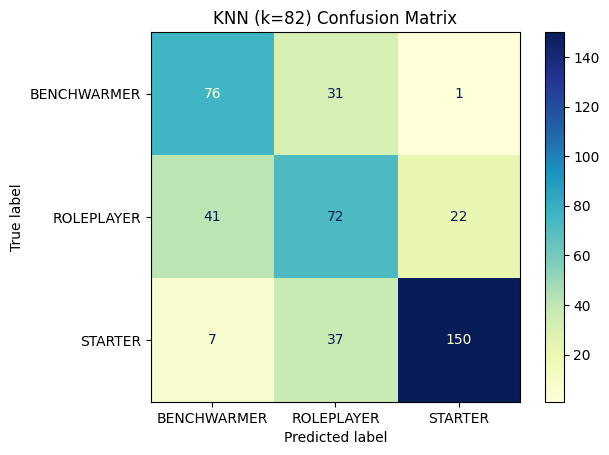

              precision    recall  f1-score   support

 BENCHWARMER       0.61      0.70      0.66       108
  ROLEPLAYER       0.51      0.53      0.52       135
     STARTER       0.87      0.77      0.82       194

    accuracy                           0.68       437
   macro avg       0.66      0.67      0.67       437
weighted avg       0.70      0.68      0.69       437



In [14]:
knn_clf = KNeighborsClassifier(n_neighbors=best_k)
knn_clf.fit(X_train, y_train)
plot_conf_mat(knn_clf, title=f"KNN (k={best_k}) Confusion Matrix")


(0.64, 0.7)

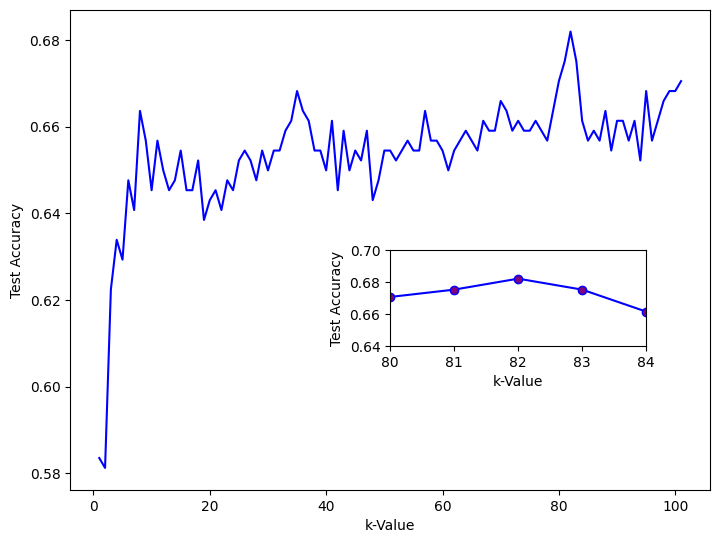

In [15]:
# k curve
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([0.5, 0.3, 0.4, 0.2])

ax1.plot(k_range, k_acc, 'b')
ax1.set_xlabel('k-Value')
ax1.set_ylabel('Test Accuracy')

ax2.plot(k_range, k_acc, 'b', marker='o', markersize=6, markerfacecolor="purple")
ax2.set_xlabel('k-Value')
ax2.set_xlim([80, 84])
ax2.set_ylabel('Test Accuracy')
ax2.set_ylim([0.64, 0.70])


Accuracy for Decision Tree (max_depth=3): 0.6568
|--- PTS <= 11.95
|   |--- PTS <= 4.75
|   |   |--- STL <= 0.55
|   |   |   |--- class: 0
|   |   |--- STL >  0.55
|   |   |   |--- class: 1
|   |--- PTS >  4.75
|   |   |--- PTS <= 7.75
|   |   |   |--- class: 1
|   |   |--- PTS >  7.75
|   |   |   |--- class: 1
|--- PTS >  11.95
|   |--- PTS <= 14.15
|   |   |--- AST <= 1.95
|   |   |   |--- class: 2
|   |   |--- AST >  1.95
|   |   |   |--- class: 2
|   |--- PTS >  14.15
|   |   |--- STL <= 0.45
|   |   |   |--- class: 1
|   |   |--- STL >  0.45
|   |   |   |--- class: 2



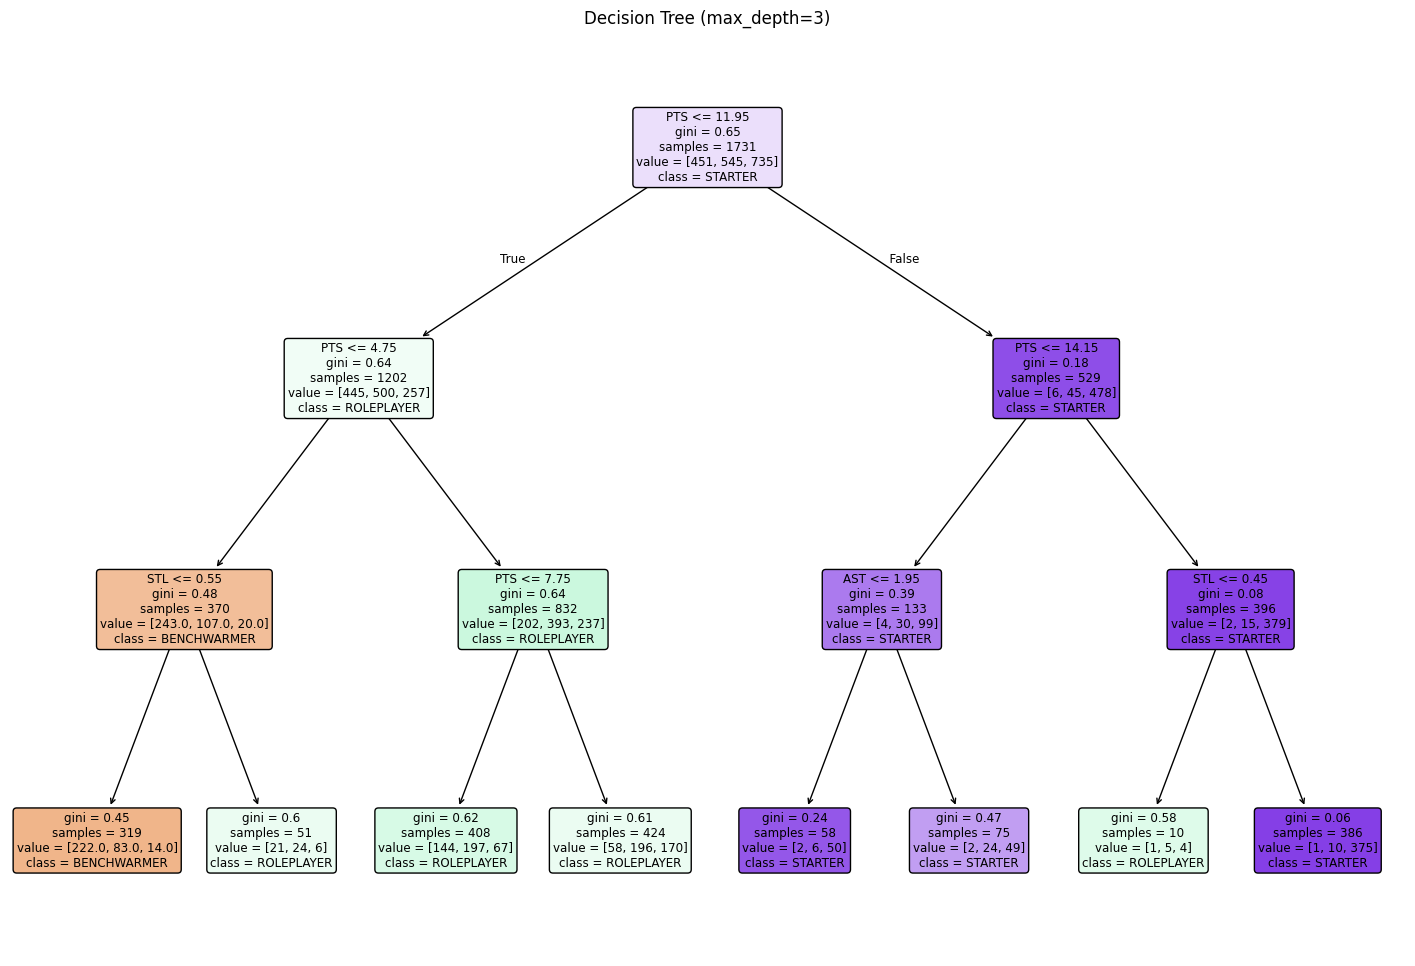

In [16]:
# Decision Tree
dt_clf = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
dt_clf.fit(X_train, y_train)
dt_acc = dt_clf.score(X_test, y_test)
print(f"Accuracy for Decision Tree (max_depth=3): {dt_acc:.4f}")
print(tree.export_text(dt_clf, feature_names=feature_cols))

# (Optional) visualize tree
plt.figure(figsize=(18, 12))
tree.plot_tree(
    dt_clf,
    feature_names=feature_cols,
    class_names=list(le.classes_),
    filled=True,
    rounded=True,
    precision=2
)
plt.title("Decision Tree (max_depth=3)")
plt.show()


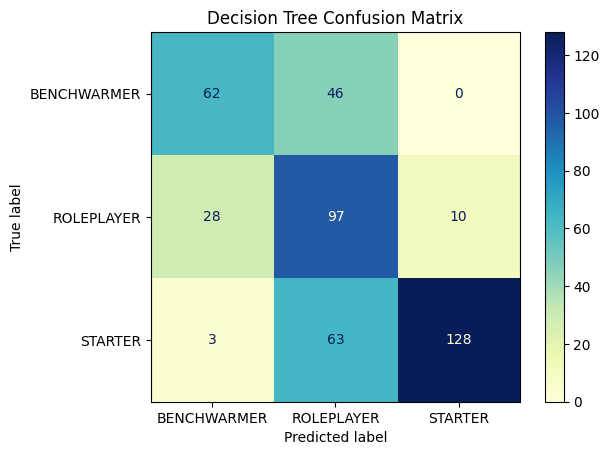

              precision    recall  f1-score   support

 BENCHWARMER       0.67      0.57      0.62       108
  ROLEPLAYER       0.47      0.72      0.57       135
     STARTER       0.93      0.66      0.77       194

    accuracy                           0.66       437
   macro avg       0.69      0.65      0.65       437
weighted avg       0.72      0.66      0.67       437



In [17]:
plot_conf_mat(dt_clf, title="Decision Tree Confusion Matrix")


In [18]:
# Grid search for best max_depth (1..10)
param_grid = {'max_depth': list(range(1, 11))}
grid_search = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), param_grid, cv=10)
grid_search.fit(X_train, y_train)
best_max_depth = grid_search.best_params_['max_depth']
print("Best max_depth via GridSearchCV:", best_max_depth)


Best max_depth via GridSearchCV: 3


Accuracy for Decision Tree (best max_depth=3): 0.6568


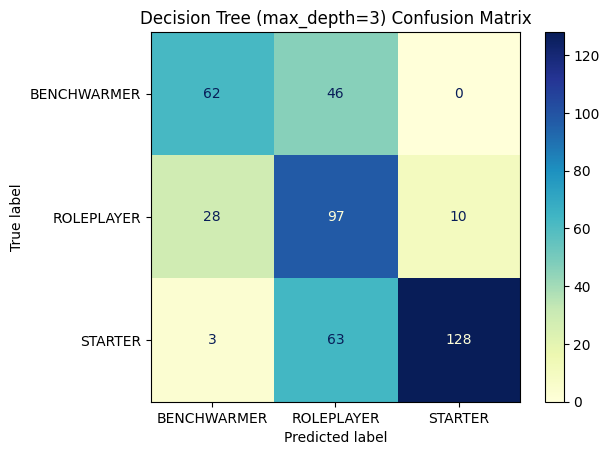

              precision    recall  f1-score   support

 BENCHWARMER       0.67      0.57      0.62       108
  ROLEPLAYER       0.47      0.72      0.57       135
     STARTER       0.93      0.66      0.77       194

    accuracy                           0.66       437
   macro avg       0.69      0.65      0.65       437
weighted avg       0.72      0.66      0.67       437



In [19]:
# Refit with best depth
dt_best = tree.DecisionTreeClassifier(random_state=42, max_depth=best_max_depth)
dt_best.fit(X_train, y_train)
print(f"Accuracy for Decision Tree (best max_depth={best_max_depth}): {dt_best.score(X_test, y_test):.4f}")
plot_conf_mat(dt_best, title=f"Decision Tree (max_depth={best_max_depth}) Confusion Matrix")


Accuracy for Naive Bayes: 0.6522


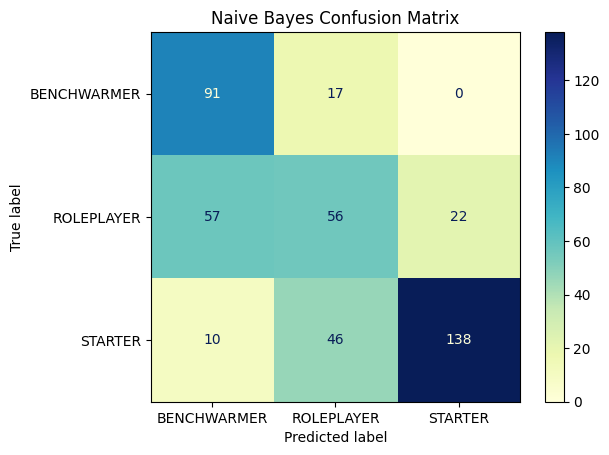

              precision    recall  f1-score   support

 BENCHWARMER       0.58      0.84      0.68       108
  ROLEPLAYER       0.47      0.41      0.44       135
     STARTER       0.86      0.71      0.78       194

    accuracy                           0.65       437
   macro avg       0.64      0.66      0.63       437
weighted avg       0.67      0.65      0.65       437



In [20]:
# Naive Bayes
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
nb_acc = nb_clf.score(X_test, y_test)
print(f"Accuracy for Naive Bayes: {nb_acc:.4f}")
plot_conf_mat(nb_clf, title="Naive Bayes Confusion Matrix")


In [21]:
# Save ML Predictions to Excel
knn_preds = le.inverse_transform(knn_clf.predict(X_test))
dt_preds  = le.inverse_transform(dt_best.predict(X_test))  # use tuned tree
nb_preds  = le.inverse_transform(nb_clf.predict(X_test))

results_df = pd.DataFrame({
    'Player': players_test,
    'True Label': true_labels,
    'KNN Prediction': knn_preds,
    'Decision Tree Prediction': dt_preds,
    'Naive Bayes Prediction': nb_preds
})

ml_results_out = ANALYSIS_DIR / "ML_Classification_analysis_dataset.xlsx"
results_df.to_excel(ml_results_out, index=False)
print(f"\nClassification results saved to: {ml_results_out}")



Classification results saved to: /content/drive/MyDrive/ACADS/CSCI 299.2/Research Paper/Datasets/ANALYSIS/ML_Classification_analysis_dataset.xlsx
